In [21]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, Embedding
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.tokenize import word_tokenize

In [2]:
df=pd.read_csv("eng-fr.csv")
#df=df.sample(40000, random_state=42)
df=df[:40000]

In [3]:
import re
# remove unwanted characters
def remove_chars(text):
    # pattern to match unwanted characters
    pattern = r'[^\w\s]'
    # replace unwanted characters with space
    text = re.sub(pattern, ' ', text)
    # remove multiple spaces
    text = re.sub('\s+', ' ', text).strip()
    return text

df = df.applymap(lambda s: s.lower())
df['English words/sentences'] = df['English words/sentences'].apply(remove_chars)
df['French words/sentences'] = df['French words/sentences'].apply(remove_chars)
eng, fr = df["English words/sentences"], df["French words/sentences"]

In [4]:
#calculate the maximum length of a sentence (nr of words)
max_len_eng_sentence = [len(s.split()) for s in eng]
max_len_fr_sentence = [len(s.split()) for s in fr]

(7, 15)

In [5]:
#create french tokenizer
fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(fr)
#get vocabulary size and maximum length of a sentence 
fr_vocab_size = len(fr_tokenizer.word_index) + 1
fr_length = max(max_len_fr_sentence)
print(fr_vocab_size)
print(fr_length)

#create english tokenizer
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(eng)
#get vocabulary size and maximum length of a sentence 
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max(max_len_eng_sentence)
print(eng_vocab_size)
print(eng_length)

9332
15
5156
7


In [6]:
#split data into train and test 
from sklearn.model_selection import train_test_split
train_eng, test_eng, train_fr, test_fr = train_test_split(eng, fr, test_size=0.1, random_state=42)

In [7]:
#fit the tokenizer and add padding to the training and testing data
train_fr_encoded = fr_tokenizer.texts_to_sequences(train_fr)
train_fr_encoded = pad_sequences(train_fr_encoded, maxlen=fr_length, padding='post')

train_eng_encoded = eng_tokenizer.texts_to_sequences(train_eng)
train_eng_encoded = pad_sequences(train_eng_encoded, maxlen=eng_length, padding='post')

test_fr_encoded = fr_tokenizer.texts_to_sequences(test_fr)
test_fr_encoded = pad_sequences(test_fr_encoded, maxlen=fr_length, padding='post')

test_eng_encoded = eng_tokenizer.texts_to_sequences(test_eng)
test_eng_encoded = pad_sequences(test_eng_encoded, maxlen=eng_length, padding='post')

test_fr_encoded.shape, test_eng_encoded.shape

((4000, 15), (4000, 7))

In [8]:
#create the model 
# create the input layer for the encoder
encoder_inputs= Input(shape=(eng_length,), name='Encoder_Input')
# create an embedding layer for the encoder input
encoder_embedding=Embedding(eng_vocab_size, 256, name='Encoder_embedding')(encoder_inputs)
# create a LSTM layer with 256 units for the encoder
encoder_lstm=LSTM(256, name='Encoder_LSTM')(encoder_embedding)
# Repeat the encoder output fr_length times
repeat_vector=RepeatVector(fr_length, name='Repeat_Vector')(encoder_lstm)

# Define a LSTM layer with 256 units for the decoder
decoder_lstm=LSTM(256, return_sequences=True, name='Decoder_LSTM')(repeat_vector)
# Define a Dense layer for the decoder output
decoder_softmax=Dense(fr_vocab_size, activation="softmax", name='Decoder_Softmax')(decoder_lstm)
# Define the model with the encoder input as input and the decoder output as output
model= Model(inputs=encoder_inputs, outputs=decoder_softmax)

# Compile the model 
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_Input (InputLayer)  [(None, 7)]               0         
                                                                 
 Encoder_embedding (Embeddin  (None, 7, 256)           1319936   
 g)                                                              
                                                                 
 Encoder_LSTM (LSTM)         (None, 256)               525312    
                                                                 
 Reperat_Vector (RepeatVecto  (None, 15, 256)          0         
 r)                                                              
                                                                 
 Decoder_LSTM (LSTM)         (None, 15, 256)           525312    
                                                                 
 Decoder_Softmax (Dense)     (None, 15, 9332)          239832

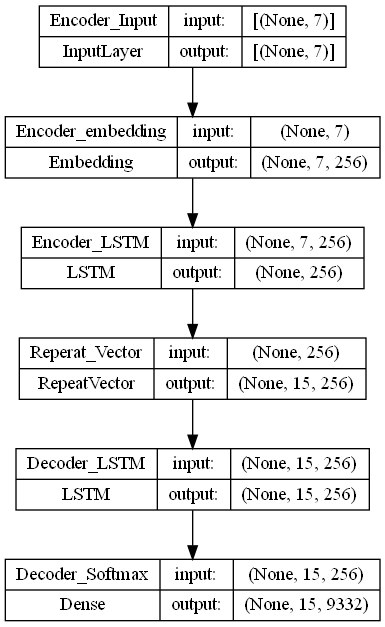

In [9]:
#plot the model
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [10]:
#create callback monitoring loss with patience 3
#stop training if loss does not improve in 3 straight epochs
callback = EarlyStopping(monitor='loss', patience=3)

#fit the model
history = model.fit(train_eng_encoded, train_fr_encoded.reshape(train_fr_encoded.shape[0], train_fr_encoded.shape[1], 1), 
          epochs=100, batch_size=512, callbacks=[callback], validation_split = 0.1, verbose=1)#callbacks=[callback],

Epoch 1/100
64/64 [==============================] - 67s 986ms/step - loss: 3.3326 - accuracy: 0.6865 - val_loss: 2.1809 - val_accuracy: 0.7102
Epoch 2/100
64/64 [==============================] - 61s 954ms/step - loss: 2.1077 - accuracy: 0.7084 - val_loss: 2.0131 - val_accuracy: 0.7158
Epoch 3/100
64/64 [==============================] - 61s 958ms/step - loss: 1.9839 - accuracy: 0.7148 - val_loss: 1.9478 - val_accuracy: 0.7156
Epoch 4/100
64/64 [==============================] - 61s 956ms/step - loss: 1.9316 - accuracy: 0.7158 - val_loss: 1.9157 - val_accuracy: 0.7169
Epoch 5/100
64/64 [==============================] - 60s 936ms/step - loss: 1.9112 - accuracy: 0.7164 - val_loss: 1.9096 - val_accuracy: 0.7175
Epoch 6/100
64/64 [==============================] - 60s 931ms/step - loss: 1.8933 - accuracy: 0.7182 - val_loss: 1.9011 - val_accuracy: 0.7217
Epoch 7/100
64/64 [==============================] - 60s 933ms/step - loss: 1.8798 - accuracy: 0.7205 - val_loss: 1.8798 - val_accuracy:

64/64 [==============================] - 60s 944ms/step - loss: 1.3835 - accuracy: 0.7832 - val_loss: 1.4466 - val_accuracy: 0.7804
Epoch 58/100
64/64 [==============================] - 61s 949ms/step - loss: 1.3759 - accuracy: 0.7841 - val_loss: 1.4625 - val_accuracy: 0.7795
Epoch 59/100
64/64 [==============================] - 60s 940ms/step - loss: 1.3696 - accuracy: 0.7847 - val_loss: 1.4471 - val_accuracy: 0.7812
Epoch 60/100
64/64 [==============================] - 60s 942ms/step - loss: 1.3634 - accuracy: 0.7855 - val_loss: 1.4335 - val_accuracy: 0.7816
Epoch 61/100
64/64 [==============================] - 61s 949ms/step - loss: 1.3582 - accuracy: 0.7860 - val_loss: 1.4254 - val_accuracy: 0.7827
Epoch 62/100
64/64 [==============================] - 60s 942ms/step - loss: 1.3511 - accuracy: 0.7867 - val_loss: 1.4250 - val_accuracy: 0.7838
Epoch 63/100
64/64 [==============================] - 61s 951ms/step - loss: 1.3444 - accuracy: 0.7872 - val_loss: 1.4377 - val_accuracy: 0.781

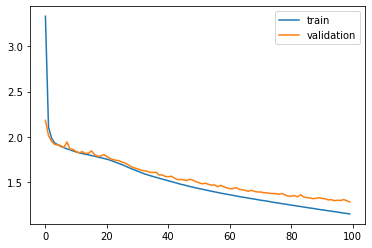

In [16]:
#save the model
model.save('seq2seq.h5')

#plot the loss history over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])

In [17]:
#Create a dictionary from word indices to words in the French vocabulary
fr_idx2word = {word:key for key, word in fr_tokenizer.word_index.items()}

#Define a function that generates prediction text from prediction tokenized sequences 
def generate_prediction_texts(pred_seqs, idx2word_map):
    pred_texts = []
    for prediction in preds:
        #create an empty list to store the translated words in the prediction sequence
        translated = []
        for i in range(len(prediction)):
            #Get the word corresponding to the current word token index in the French vocabulary, or None if not found
            word_pred = fr_idx2word.get(prediction[i], None)
            if i > 0:
                #if the current word is the same as the previous word, add an empty string to the list
                if (word_pred == fr_idx2word.get(prediction[i-1], None)) or (word_pred == None):
                    translated.append('')
                #add the current word to the translated list
                else:
                    translated.append(word_pred)    
            else:
                #If this is the first word in the sequence and it is None, add an empty string to the translated list
                if(word_pred == None):
                    translated.append('')
                #Otherwise, add the current word to the translated list
                else:
                    translated.append(word_pred)        
        #Join the translated words into a string and add it to the list of predicted texts
        pred_texts.append(' '.join(translated))
    #Return predicted texts
    return pred_texts

In [18]:
#get the model
model=load_model('./seq2seq.h5')

In [23]:
# Predict the target sequences for the test data
pred_probs = model.predict(test_eng_enc.reshape((test_eng_enc.shape[0], test_eng_enc.shape[1])), verbose=1)
preds = [np.argmax(i, axis=1) for i in pred_probs]

#convert the prediction from indices to text using the function defined before
pred_texts = generate_prediction_texts(pred_seqs=preds, idx2word_map=fr_idx2word)
#plot the original english sentence, the target french and the predicted french
pred_df = pd.DataFrame({'source': test_eng, 'target' : test_fr, 'predicted' : pred_texts})
pred_df.head(50)

125/125 [==============================] - 5s 41ms/step


,source,target,predicted
13787,don t talk to me,ne me parle pas,ne me pas
5128,he is awesome,il est génial,il est
9125,they quarreled,elles se sont disputées,elles ont
35041,i have a bad sunburn,j ai un mauvais coup de soleil,j ai un


In [24]:
pred_df[11:16]

,source,target,predicted
13787,don t talk to me,ne me parle pas,ne me pas
5128,he is awesome,il est génial,il est
9125,they quarreled,elles se sont disputées,elles ont
35041,i have a bad sunburn,j ai un mauvais coup de soleil,j ai un
3510,i am working,je suis en train de travailler,je suis


In [22]:
#Tokenize the test sentences and predicted translations
ref_tokenized = [[word_tokenize(sentence.lower())] for sentence in test_fr]
pred_tokenized = [word_tokenize(sentence.lower()) for sentence in pred_texts]

#Compute BLEU score
bleu_scores = []
for i in range(len(pred_tokenized)):
    bleu_scores.append(sentence_bleu(ref_tokenized[i], pred_tokenized[i]))

#Compute corpus-level BLEU score
corpus_bleu_score = corpus_bleu(ref_tokenized, pred_tokenized)

print(f"Average BLEU score: {np.mean(bleu_scores):.4f}")
print(f"Corpus-level BLEU score: {corpus_bleu_score:.4f}")

C:\Users\lucas\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\lucas\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\lucas\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

Average BLEU score: 0.0319
Corpus-level BLEU score: 0.1193
